In [1]:
from src.data import load_data
from src.models import util_model
from src.data import util

In [2]:
image_name = "trans012" 
front_image_name = image_name + "-1"
back_image_name = image_name + "-2"
front_image_path = "data/raw/front"
back_image_path = "data/raw/back"
front_image = load_data.read_image(front_image_path, front_image_name)
back_image = load_data.read_image(back_image_path, back_image_name)

In [3]:
front_section_dict = util_model.detect_section(front_image, util_model.front_model)
pf_sections = util.pre_process(front_section_dict)
front_text_dict = util_model.images_to_texts(pf_sections)
courses_df = util.make_course(front_text_dict)
error_df = util.get_error(courses_df)
error_df


0: 640x448 3 sections, 808.8ms
Speed: 2.7ms preprocess, 808.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


,ocr,numeric,section,ref,id,name,unit,grade


In [4]:
post_courses_df = util.post_process(courses_df, pf_sections)
post_error_df = util.get_error(post_courses_df).reset_index(drop=True)
post_error_df

,ocr,numeric,section,ref,id,name,unit,grade


In [5]:
back_section_dict = util_model.detect_section(back_image, util_model.back_model)
pb_sections = util.pre_process(back_section_dict)
back_text_dict = util_model.images_to_texts(pb_sections)
gpa = util.get_GPA(back_text_dict[0])
gpa


0: 640x480 1 section, 872.7ms
Speed: 4.8ms preprocess, 872.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


,ocr,category,unit,grade
0,กก ภาษาไทย 50,ภาษาไทย,9.99,999.00
1,กข คณิตศาสตร์ 6.5 4.00,คณิตศาสตร์,6.50,4.00
2,กค (วิทยาศาสตร์และเทคโนโลยี 115 3.82,วิทยาศาสตร์,1.15,3.82
3,กญ (สังคมศึกษา ศาสนา และวัฒนธรรม 7.0 3.92,สังคมศึกษา,7.00,3.92
4,กฐ สุขศึกษาและพลศึกษา 50 4.00,สุขศึกษา,50.00,4.00
5,กท ศิลปะ 25 380,ศิลปะ,25.00,3.80
6,กย การงานอาชีพ 25 400,การงานอาชีพ,25.00,4.00
7,กพ [ภาษาต่างประเทศ 310 400,ภาษาต่างประเทศ,3.10,4.00
8,ภูล ผลการเรียนเฉลี่ยดลอดหลักสูตร 73.0 3.95,ผลการเรียน,0.73,3.95


In [6]:
post_courses_df

,ocr,numeric,section,ref,id,name,unit,grade
0,กข ท31101 ภาษาไทยพื้นฐาน 1 10 4,3111 1 1 4,000,กข,ท31101,ภาษาไทยพื้นฐาน,1.0,4.0
1,กค ค31101 คณิตศาสตร์พื้นฐาน 1 15 4,3111 1 15 4,001,กค,ค31101,คณิตศาสตร์พื้นฐาน,1.5,4.0
2,กญ ว30114 วิทยาการคํานวณและการออกแบบ 1.5 3.5,3114 155 355,002,กญ,ว30114,วิทยาการคํานวณและการออกแบบ,1.5,3.5
3,กฐ ส31101 สังคมศึกษาพีนฐาน 1 10 35,3111 1 1 35,003,กฐ,ส31101,สังคมศึกษาพีนฐาน,1.0,3.5
4,กท พ31101 สุขศึกษาพลศึกษา 1 05 4,3111 1 5 4,004,กท,พ31101,สุขศึกษาพลศึกษา,0.5,4.0
...,...,...,...,...,...,...,...,...
71,คอ จ32206 สนหนาภาษาจีน 4 05 4,4 5 4,227,คอ,จ32206,สนหนาภาษาจีน,0.5,4.0
72,ญก ญ32202 ภาษาญี่ปุ่น 4 30 4,4 3 4,228,ญก,ญ32202,ภาษาญี่ปุ่น,3.0,4.0
73,ญข 032202 สนทนาภาษายอังกฤษ ๕ 05 4,5 4,229,ญข,อ32202,สนทนาภาษายอังกฤษ,0.5,4.0
74,ญค อ32212 ภาษาอังกฤษเพื่อการสือสาร 2 10 4,2 1 4,230,ญค,อ32212,ภาษาอังกฤษเพื่อการสือสาร,1.0,4.0


In [7]:
front_edf = post_courses_df[["section", "id", "name", "unit", "grade"]]
back_edf = gpa[["category", "unit", "grade"]]

In [8]:
front_edf

,section,id,name,unit,grade
0,000,ท31101,ภาษาไทยพื้นฐาน,1.0,4.0
1,001,ค31101,คณิตศาสตร์พื้นฐาน,1.5,4.0
2,002,ว30114,วิทยาการคํานวณและการออกแบบ,1.5,3.5
3,003,ส31101,สังคมศึกษาพีนฐาน,1.0,3.5
4,004,พ31101,สุขศึกษาพลศึกษา,0.5,4.0
...,...,...,...,...,...
71,227,จ32206,สนหนาภาษาจีน,0.5,4.0
72,228,ญ32202,ภาษาญี่ปุ่น,3.0,4.0
73,229,อ32202,สนทนาภาษายอังกฤษ,0.5,4.0
74,230,อ32212,ภาษาอังกฤษเพื่อการสือสาร,1.0,4.0


In [9]:
back_edf

,category,unit,grade
0,ภาษาไทย,9.99,999.00
1,คณิตศาสตร์,6.50,4.00
2,วิทยาศาสตร์,1.15,3.82
3,สังคมศึกษา,7.00,3.92
4,สุขศึกษา,50.00,4.00
5,ศิลปะ,25.00,3.80
6,การงานอาชีพ,25.00,4.00
7,ภาษาต่างประเทศ,3.10,4.00
8,ผลการเรียน,0.73,3.95


In [10]:
load_data.export_df_to_csv("data/out/csv/front", front_image_name, front_edf)
load_data.csv_to_json("data/out/json/front", "data/out/csv/front", front_image_name)
load_data.export_df_to_csv("data/out/csv/back", back_image_name, back_edf)
load_data.csv_to_json("data/out/json/back", "data/out/csv/back", back_image_name)

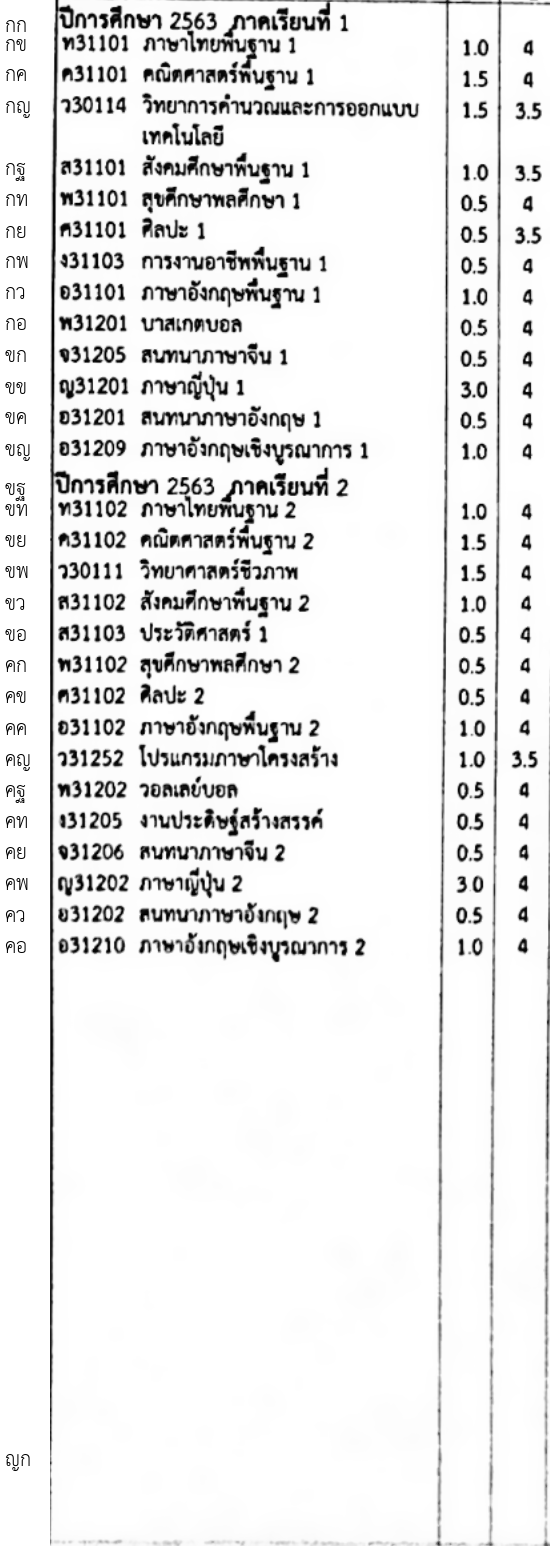

In [11]:
pf_sections[0]

In [12]:
import pandas as pd

In [13]:
d = pd.DataFrame({"A": [1, 2, 3, 4],
                  "B": [1, 2, 3, 4]
                  }
)

In [14]:
(d.A - d.A.shift(1)).abs().fillna(0)

0    0.0
1    1.0
2    1.0
3    1.0
Name: A, dtype: float64